In [1]:
import numpy as np
from PIL import Image
import pandas as pd
import os
import imageio
import shutil
import re

from sklearn.preprocessing import LabelEncoder, OneHotEncoder


import keras
from keras import Model, layers, optimizers, callbacks, Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, BatchNormalization
from keras.layers import regularizers, Flatten, Convolution2D, Activation
from keras.wrappers.scikit_learn import KerasClassifier

%matplotlib inline
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt

Using TensorFlow backend.


# Question 1

## 1d conv

In [2]:
def conv_1d(array, kernel, stride=1, padding_element=0, padding_size=0):
    if padding_size>0:
        pad = np.repeat(padding_element, padding_size)
        array = np.hstack([pad, array, pad])
    n = array.size
    k = kernel.size
    indices = np.vstack([np.arange(i, (i+k)) for i in range(0, n-k+1, stride)])
    return (array[indices]*kernel).sum(axis=1)

In [3]:
F =  np.array([int(i) for i in '1 2 1 3 2 3 1 2 3 8 7 8 9 9 7 8'.split(' ')])
W1 = np.array([1, 1, 1])
W2 = np.array([1, 0, -1])
print(F)
print(W1)
print(W2)

[1 2 1 3 2 3 1 2 3 8 7 8 9 9 7 8]
[1 1 1]
[ 1  0 -1]


In [4]:
print(conv_1d(F, W1))
print(conv_1d(F, W2))

[ 4  6  6  8  6  6  6 13 18 23 24 26 25 24]
[ 0 -1 -1  0  1  1 -2 -6 -4  0 -2 -1  2  1]


## 2d convs

In [5]:
def plot_figures(figures, nrows = 1, ncols=2, ht=18.5, wd=10.5):
    """Plot a dictionary of figures.

    Parameters
    ----------
    figures : <title, figure> dictionary
    ncols : number of columns of subplots wanted in the display
    nrows : number of rows of subplots wanted in the figure
    """

    fig, axeslist = plt.subplots(ncols=ncols, nrows=nrows)
    fig.set_size_inches(ht, wd, forward=True)
    for ind,title in enumerate(figures):
        axeslist.ravel()[ind].imshow(figures[title], cmap=plt.gray())
        axeslist.ravel()[ind].set_title(title)
        axeslist.ravel()[ind].set_axis_off()
    plt.tight_layout() # optional


def conv_2d_1channel(image, kernel_2d, stride=1, padding_element=0, padding_size=0):
    image_shape = image.shape
    h = image_shape[0]
    w = image_shape[1]
    
    kernel_shape = kernel_2d.shape
    h_k = kernel_shape[0]
    w_k = kernel_shape[1]
    final_shape = len(range(0, h-h_k+1, stride)), len(range(0, w-w_k+1, stride))
    new_image = np.zeros(final_shape)
    for i in range(0, h-h_k+1, stride):
        for j in range(0, w-w_k+1, stride):
            window = image[i:(i+h_k), j:(j+w_k)]
            new_image[i,j] = (window*kernel_2d).sum()
            
#     new_image = new_image/(255*h_k*w_k) if scale else new_image
    plot_figures({'original': I, 'transformed': new_image})     
    return new_image

(array([[164, 188, 164, 161, 195],
        [178, 201, 197, 150, 137],
        [174, 168, 181, 190, 184],
        [131, 179, 176, 185, 198],
        [ 92, 185, 179, 133, 167]]),
 <matplotlib.image.AxesImage at 0x7f1c3e620c88>)

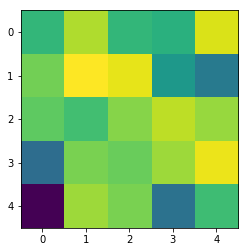

In [6]:
rows = '''164 188 164 161 195
178 201 197 150 137
174 168 181 190 184
131 179 176 185 198
92 185 179 133 167'''.split('\n')

elements = [r.split(' ') for r in rows]
I = np.array([int(element) for r in elements for element in r]).reshape((5, 5))
I, imshow(I)

array([[1615., 1600., 1559.],
       [1585., 1627., 1598.],
       [1465., 1576., 1593.]])

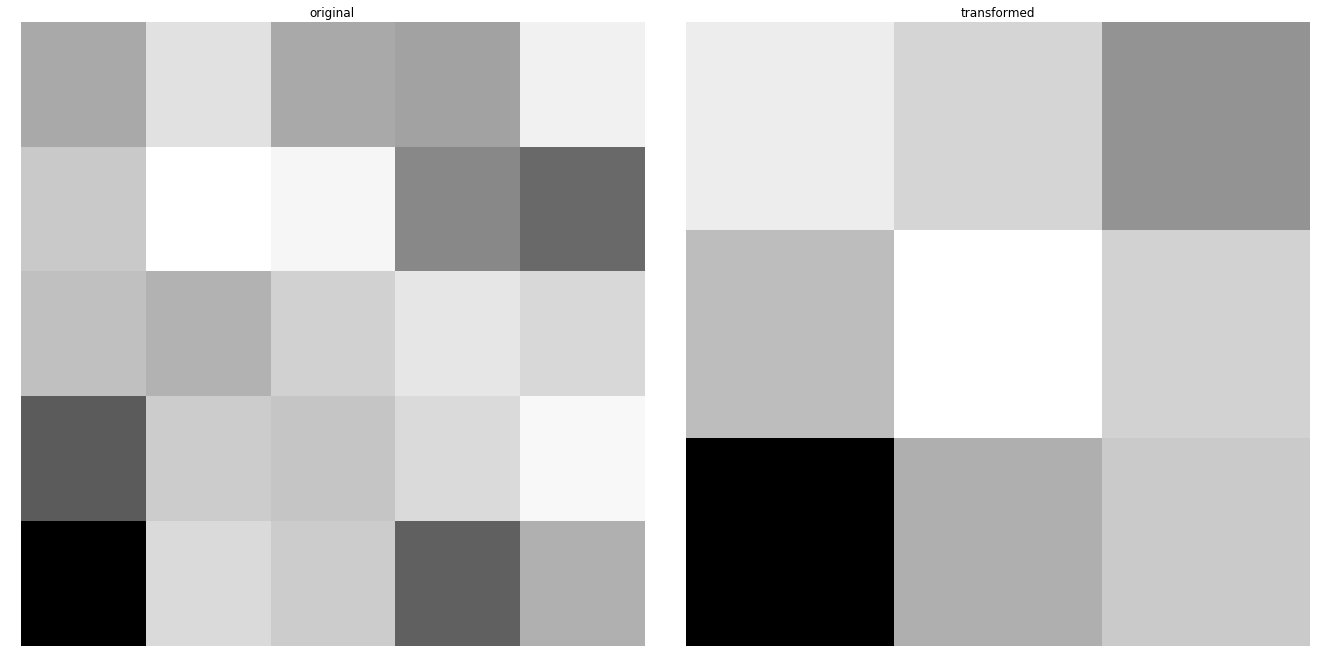

In [7]:
F1 = np.ones((3, 3))
conv_2d_1channel(I, F1)

array([[ -13.,   43.,   64.],
       [-112.,  -29.,  110.],
       [ -50.,  -44., -133.]])

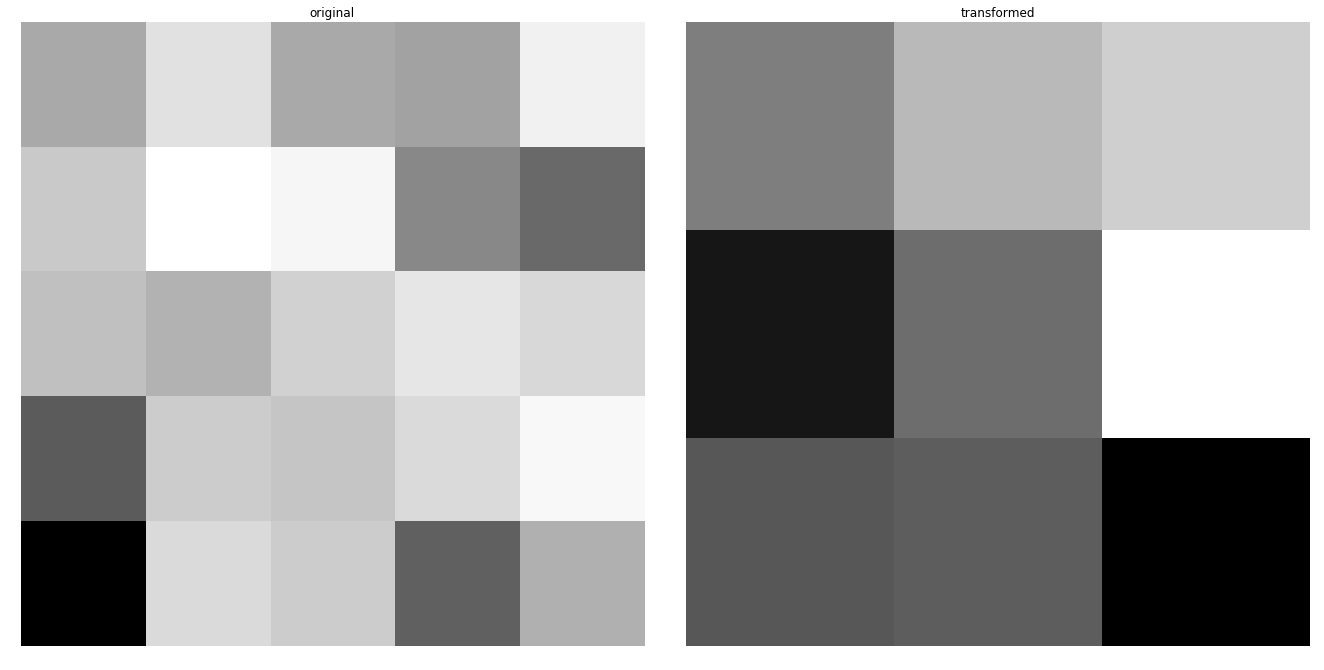

In [8]:
F2 = np.array([
    [-1, -2, -1],
    [0, 0, 0],
    [1, 2, 1]
])
conv_2d_1channel(I, F2)

array([[395., 370., -59.],
       [ 95., 183., 302.],
       [325., 184., 257.]])

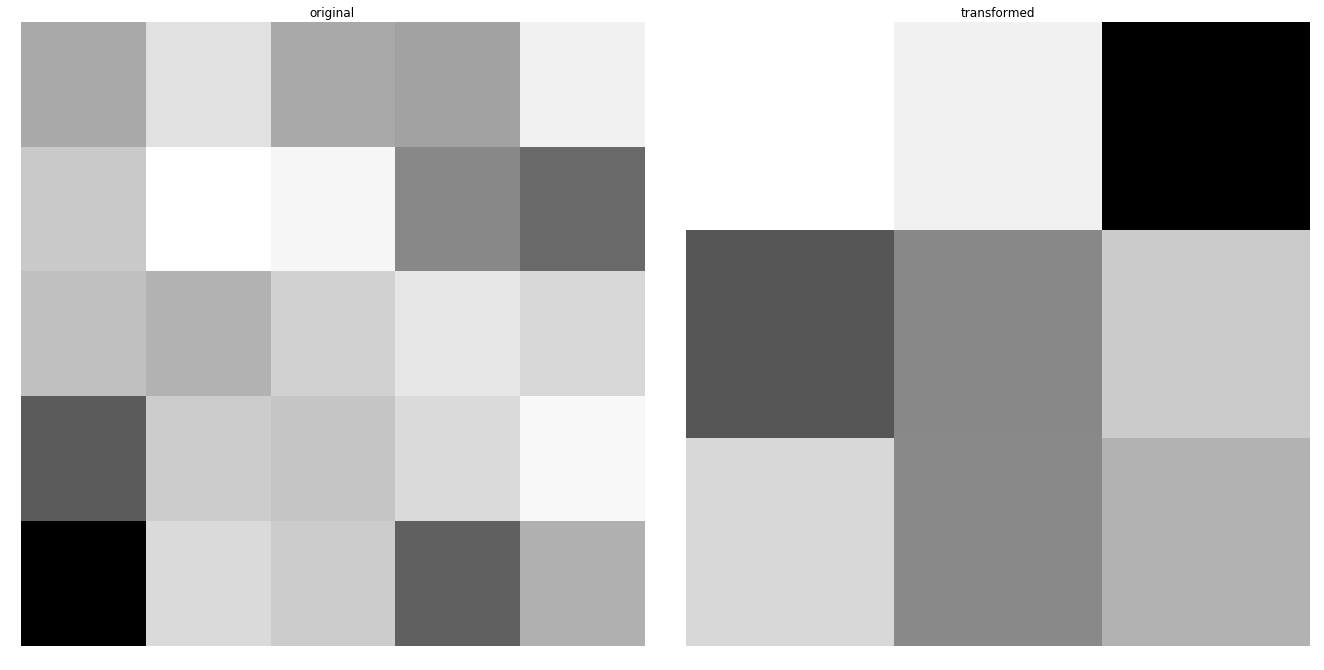

In [9]:
F2 = np.array([
    [-1, -1, -1],
    [-1, 9, -1],
    [-1, -1, -1]
])
conv_2d_1channel(I, F2)

# Question 2

In [10]:
path_data_yale = 'data/yalefaces/'
img_files = os.listdir(path_data_yale)
img_files[:5]

['subject13.normal.gif',
 'subject14.happy.gif',
 'subject03.noglasses.gif',
 'subject01.wink.gif',
 'subject05.noglasses.gif']

In [11]:
for i in img_files:
    path_image = path_data_yale+i
    if '.gif' not in path_image:
        new_name = path_image+'.gif'
        shutil.move(path_image, new_name)
img_files = os.listdir(path_data_yale)

In [12]:
img = []
class_ = []
subject = []

re_subject_no = re.compile('^subject(\d+)')
re_class = re.compile('^subject\d+.([A-Za-z]+)')

for i in img_files:
    subject.append(int(re.findall(re_subject_no, i)[0]))
    class_.append(re.findall(re_class, i)[0])
    path_image = path_data_yale+i
    img.append(np.expand_dims(imageio.imread(path_image), axis=0))
    
img = np.vstack(img)
subject = np.array(subject)-1

le = LabelEncoder()
class_ = le.fit_transform(class_)

print(img.shape)
print(class_.shape)
print(subject.shape) 

(165, 243, 320)
(165,)
(165,)


In [13]:
def split(img_class_subs, 
          test_samples_per_subject=1,
          val_samples_per_subject=1, 
          create_validation_set=False,
          seed=np.random.randint(0, 1000, size=1)):
    np.random.seed(seed)
    imgs, subjects, classes = img_class_subs
    order = subjects.argsort()
    imgs, subjects, classes = imgs[order], subjects[order], classes[order]
    sub_counts = np.unique(subjects, return_counts=True)    
    selections = np.hstack([np.repeat(0, sub_counts[1][1]-test_samples_per_subject), 
                            np.repeat(1, test_samples_per_subject)])
    test_selection = np.vstack(
                [np.expand_dims(
                    np.random.choice(selections, 
                                     size=selections.size, 
                                     replace=False), 
                    axis=0) 
                 for i in range(sub_counts[0].size)]
            )
    test_selection = (test_selection==1).reshape((-1))
    train_selection = (test_selection==0).reshape((-1))
    test_set = (imgs[test_selection], subjects[test_selection], classes[test_selection])
    train_set = (imgs[train_selection], subjects[train_selection], classes[train_selection])
    if create_validation_set:
        train_set, val_set = split(train_set, test_samples_per_subject=val_samples_per_subject)
        return train_set, val_set, test_set
    else:
        return unison_shuffled_copies(*train_set), unison_shuffled_copies(*test_set)
    
def unison_shuffled_copies(a, b, c):
    p = np.random.permutation(a.shape[0])
    return a[p], b[p], c[p]

(135, 243, 320) (135,) (135,)
(30, 243, 320) (30,) (30,)


(<matplotlib.image.AxesImage at 0x7f1c377479b0>, 0)

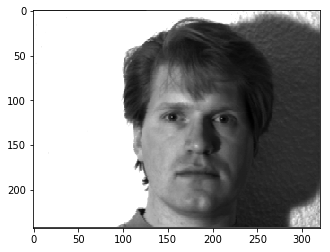

In [14]:
train_set, test_set = split((img, subject, class_), test_samples_per_subject=2, seed=1)
tr_X_org = train_set[0]/255
tr_X = tr_X_org.reshape(tr_X_org.shape[0], -1)
tr_y = train_set[1]

ts_X_org = test_set[0]/255
ts_X = ts_X_org.reshape(ts_X_org.shape[0], -1)
ts_y = test_set[1]


h = train_set[0][0].shape[0]
w = train_set[0][0].shape[1]

print(tr_X_org.shape, tr_y.shape, train_set[2].shape)
print(ts_X_org.shape, ts_y.shape, test_set[2].shape)
imshow(test_set[0][0]), test_set[1][0]

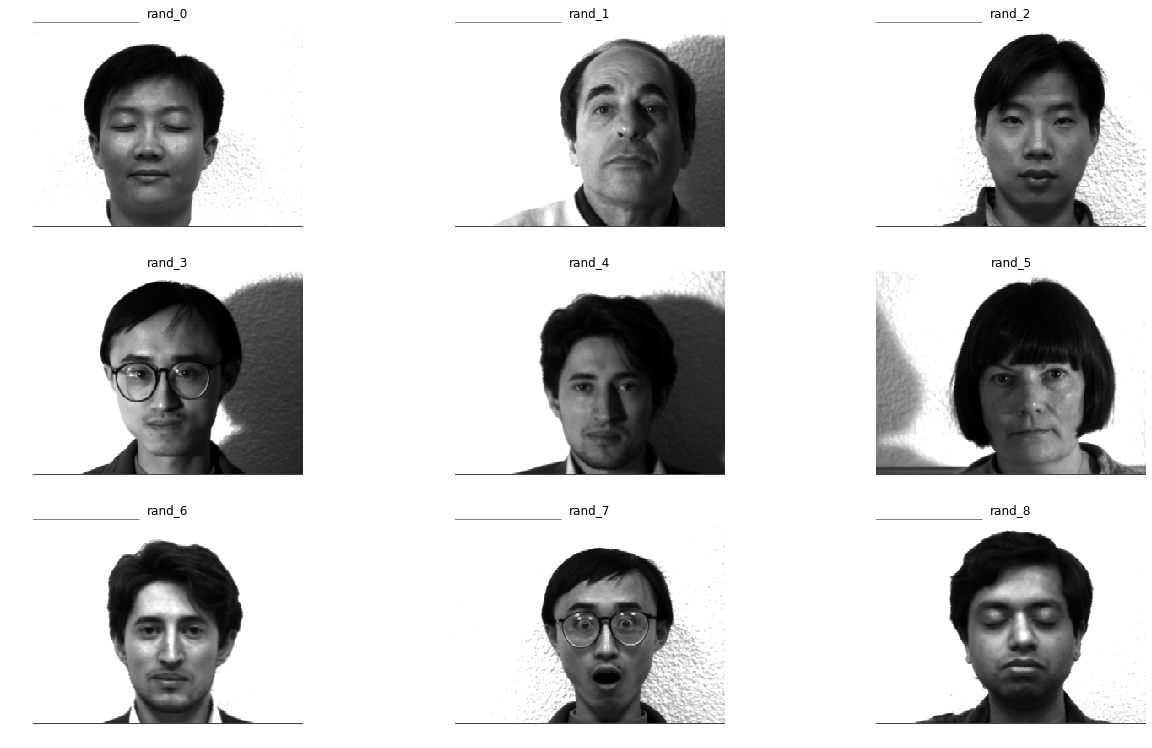

In [15]:
plot_figures({f'rand_{i}':img[np.asscalar(np.random.randint(0, 166, 1))] for i in range(9)}, nrows=3, ncols=3)

In [45]:
np.unique(subject, return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 array([11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11]))

In [24]:
# l = int((320-243)/2)
# r = l+1
# img[:30, :, l:-r].shape
# img_sample = img[:30].reshape((30, -1))
# print(img_sample.shape)
# np.linalg.eig(np.cov(tr_X, rowvar=False))

import scipy.spatial.distance as dist

print(tr_X.shape)
dist.pdist(tr_X.T, metric='correlation').shape
# np.cov(tr_X).shape

(135, 77760)


MemoryError: 

In [47]:
class PCA_image:
    
    def __init__(self, k):
        self.k = k
        
    def reshape(self, img:np.array):
        return img.reshape((img.shape[0], -1))
        
    
    def fit(self, X):
        self.X_org = X
        self.X = self.reshape(X)
        self.cov = np.cov(self.X) #, rowvar=False
        eig = np.linalg.eig(self.cov)
        eig_ord = -eig[0].argsort()
        self.eig_vals = eig[0][eig_ord]
        self.eig_vectors = eig[1][eig_ord]
    
    def transform(self, ts_X):
        eig_vecs = self.eig_vectors[:self.k]
        return eig_vecs.dot(self.reshape(ts_X))


In [48]:
# pca = PCA_image(k=3)
# pca.fit(img)
# pca.transform(img[:5]).shape

In [49]:
tr_X.shape

(135, 77760)

In [50]:
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline, make_union, Pipeline, FeatureUnion
from sklearn.model_selection import GridSearchCV

model_pipeline = Pipeline([
                        ('pca', PCA(5)),
                        ('rf', RandomForestClassifier(n_estimators=100))
                    ])

# pca = PCA(5)
# pca.fit(tr_X)
# components = pca.transform(tr_X)

param_grid = {
    'pca__n_components':range(1, 30, 3)
}

model_cv_best = GridSearchCV(model_pipeline, 
                             param_grid=param_grid, 
                             cv=7, 
                             verbose=True, 
                             n_jobs=-1, 
                             iid=False,
                            return_train_score=False)
model_cv_best.fit(tr_X, tr_y)
model_cv_best.score(ts_X, ts_y)


# model_pipeline.fit(tr_X/255, tr_y)
# model_pipeline.score(ts_X/255, ts_y)


Fitting 7 folds for each of 10 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   20.2s
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:   42.5s finished


0.9666666666666667

In [51]:
print(model_cv_best.best_params_)
pd.DataFrame(model_cv_best.cv_results_)

{'pca__n_components': 28}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_pca__n_components,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,mean_test_score,std_test_score,rank_test_score
0,3.058696,0.273298,0.095801,0.047464,1,{'pca__n_components': 1},0.300000,0.233333,0.466667,0.266667,0.200000,0.333333,0.400000,0.314286,0.087027,10
1,3.573263,0.363768,0.096627,0.034638,4,{'pca__n_components': 4},0.600000,0.600000,0.733333,0.600000,0.666667,0.666667,0.733333,0.657143,0.055533,9
2,3.596291,0.422822,0.117286,0.034035,7,{'pca__n_components': 7},0.666667,0.666667,0.866667,0.600000,0.666667,0.666667,0.933333,0.723810,0.115077,8
3,4.759603,0.479164,0.114487,0.035146,10,{'pca__n_components': 10},0.633333,0.733333,0.866667,0.600000,0.866667,0.800000,0.866667,0.766667,0.105409,7
4,3.877067,0.388308,0.124336,0.050647,13,{'pca__n_components': 13},0.700000,0.766667,0.866667,0.666667,0.800000,0.800000,0.866667,0.780952,0.070951,6
5,4.226101,0.366032,0.094087,0.031522,16,{'pca__n_components': 16},0.766667,0.733333,0.933333,0.733333,0.800000,0.800000,0.866667,0.804762,0.067679,5
6,4.853782,0.482817,0.122959,0.032761,19,{'pca__n_components': 19},0.733333,0.800000,0.933333,0.866667,0.866667,0.933333,0.933333,0.866667,0.071270,4
7,4.918031,0.293655,0.168653,0.035768,22,{'pca__n_components': 22},0.766667,0.900000,0.933333,0.800000,0.933333,0.933333,0.933333,0.885714,0.066326,2
8,5.611341,0.266492,0.136870,0.032529,25,{'pca__n_components': 25},0.833333,0.966667,0.933333,0.733333,0.866667,0.866667,0.933333,0.876190,0.072843,3
9,5.447862,0.562247,0.080039,0.067135,28,{'pca__n_components': 28},0.900000,0.933333,0.933333,0.800000,0.866667,0.933333,0.933333,0.900000,0.047140,1


In [87]:
def reconstruct_set(n_components, X):    
    pca = PCA(n_components)
    components = pca.fit_transform(X)
    return pca.inverse_transform(components).reshape((components.shape[0], h, w))

def get_reconstructed_progress(ncomps=range(1, 135, 5)):
    return {n_comp:reconstruct_set(n_comp, tr_X) for n_comp in ncomps}
    

reconstructed_progress = get_reconstructed_progress()

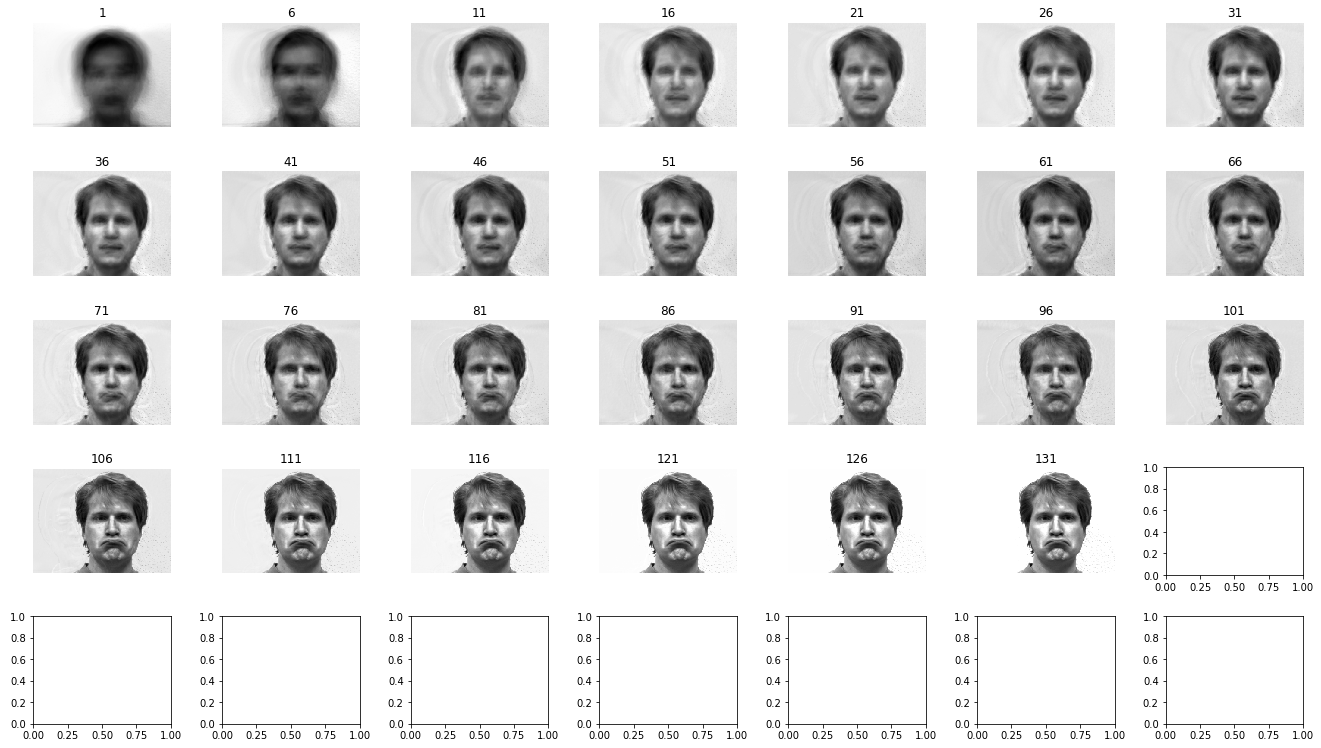

In [88]:
def plot_reconstructed_progress_for_image(image_index=0):
    img = {k:v[image_index] for k,v in reconstructed_progress.items()} #range(len(reconstructed_progress))
    plot_figures(img, nrows=5, ncols=7)

plot_reconstructed_progress_for_image(34)

## CNN

In [103]:
train_subset, validation_set = split(train_set, test_samples_per_subject=2, seed=2)


tr_y = train_set[1]
tr_sub_y = train_subset[1]
val_y = validation_set[1]
ts_y = test_set[1]

tr_sub_X = train_subset[0].reshape(train_subset[0].shape[0], h, w, 1)/255
tr_X = train_set[0].reshape(train_set[0].shape[0], h, w, 1)/255
val_X = validation_set[0].reshape(validation_set[0].shape[0], h, w, 1)/255
ts_X = test_set[0].reshape(test_set[0].shape[0], h, w, 1)/255
print(tr_sub_X.shape)


# ohe = OneHotEncoder()
# tr_sub_y_ohe = ohe.fit_transform(tr_sub_y.reshape(-1, 1)).todense()
# tr_y_ohe = ohe.transform(tr_y.reshape(-1, 1)).todense()
# val_y_ohe = ohe.transform(val_y.reshape(-1, 1)).todense()
# ts_y_ohe = ohe.transform(ts_y.reshape(-1, 1)).todense()

(105, 243, 320, 1)


4

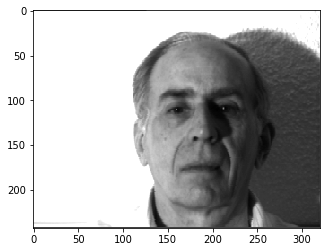

In [25]:
imshow(tr_sub_X[1][:,:,0])
# tr_sub_y_ohe[1], 
tr_sub_y[1]

In [98]:
def conv_block(n, input_layer=False):
    conv_layer = (Convolution2D(n, (3,3), input_shape=tr_sub_X.shape[1:]) 
                  if input_layer 
                  else Convolution2D(n, (3,3)))
    return Sequential([
        conv_layer,
#         BatchNormalization(),
        Activation(activation='relu'),
        Dropout(0.35),
        MaxPooling2D(strides=(2, 2))
    ])
    

def Model_Factory(conv_activations=[10, 15, 25, 25, 25, 25]):
    # CONV/FC -> BatchNorm -> ReLu(or other activation) -> Dropout -> CONV/FC ->
    # Conv > Normalization > Activation > Dropout > Pooling
    
    model = Sequential()
    
    for i,n in enumerate(conv_activations):
        model.add(conv_block(n, input_layer=(i==0)))
    
    model.add(Flatten())
    model.add(Dense(15, activation='softmax'))
    
    model.compile(optimizer=optimizers.rmsprop(lr=1e-3), 
                  loss='sparse_categorical_crossentropy', 
                  metrics=['acc'])
    
    print(model.summary())
    
#     model.score = model.evaluate

    return model 

def get_callbacks(vbose=False):
    callback_list = [
        callbacks.ModelCheckpoint('data/best_model_acc.h5', 
                                  monitor='val_acc', 
                                  save_best_only=True, 
                                  verbose=vbose),
        callbacks.ModelCheckpoint('data/best_model_loss.h5', 
                                  monitor='val_loss', 
                                  save_best_only=True, 
                                  verbose=vbose),
        callbacks.ReduceLROnPlateau(factor=0.9, 
                                    monitor='val_acc', 
                                    save_best_only=True, 
                                    verbose=vbose)
    ]
    return callback_list

model = Model_Factory()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_37 (Sequential)   (None, 120, 159, 10)      100       
_________________________________________________________________
sequential_38 (Sequential)   (None, 59, 78, 15)        1365      
_________________________________________________________________
sequential_39 (Sequential)   (None, 28, 38, 25)        3400      
_________________________________________________________________
sequential_40 (Sequential)   (None, 13, 18, 25)        5650      
_________________________________________________________________
sequential_41 (Sequential)   (None, 5, 8, 25)          5650      
_________________________________________________________________
sequential_42 (Sequential)   (None, 1, 3, 25)          5650      
_________________________________________________________________
flatten_6 (Flatten)          (None, 75)                0         
__________

In [90]:
model.fit(tr_sub_X, tr_sub_y, 
          epochs=100, batch_size=10, 
          validation_data =(val_X, val_y), 
          callbacks=get_callbacks())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_23 (Sequential)   (None, 120, 159, 10)      100       
_________________________________________________________________
sequential_24 (Sequential)   (None, 59, 78, 15)        1365      
_________________________________________________________________
sequential_25 (Sequential)   (None, 28, 38, 25)        3400      
_________________________________________________________________
sequential_26 (Sequential)   (None, 13, 18, 25)        5650      
_________________________________________________________________
sequential_27 (Sequential)   (None, 5, 8, 25)          5650      
_________________________________________________________________
sequential_28 (Sequential)   (None, 1, 3, 25)          5650      
_________________________________________________________________
flatten_4 (Flatten)          (None, 75)                0         
__________

In [37]:
model.load_weights('data/best_model.h5')
model.evaluate(ts_X, ts_y), model.evaluate(val_X, val_y)

30/30 [==============================] - 0s 8ms/step


([1.0662306547164917, 0.8333333134651184], [1.110913634300232, 1.0])

In [104]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

model_skeras = KerasClassifier(build_fn=Model_Factory, 
                                epochs=10, 
                                batch_size=10, 
                                verbose=1,
        #                         validation_data =(val_X, val_y),
#                                 callbacks=get_callbacks()
                              )

results = cross_val_score(model_skeras, tr_X, tr_y, cv=2)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_51 (Sequential)   (None, 120, 159, 10)      100       
_________________________________________________________________
sequential_52 (Sequential)   (None, 59, 78, 15)        1365      
_________________________________________________________________
sequential_53 (Sequential)   (None, 28, 38, 25)        3400      
_________________________________________________________________
sequential_54 (Sequential)   (None, 13, 18, 25)        5650      
_________________________________________________________________
sequential_55 (Sequential)   (None, 5, 8, 25)          5650      
_________________________________________________________________
sequential_56 (Sequential)   (None, 1, 3, 25)          5650      
_________________________________________________________________
flatten_8 (Flatten)          (None, 75)                0         
__________

In [105]:
results

array([0.3382353 , 0.41791046])